# Scikit-image testbench for image classification

## First steps: import and show an image with scikit-image


In [134]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

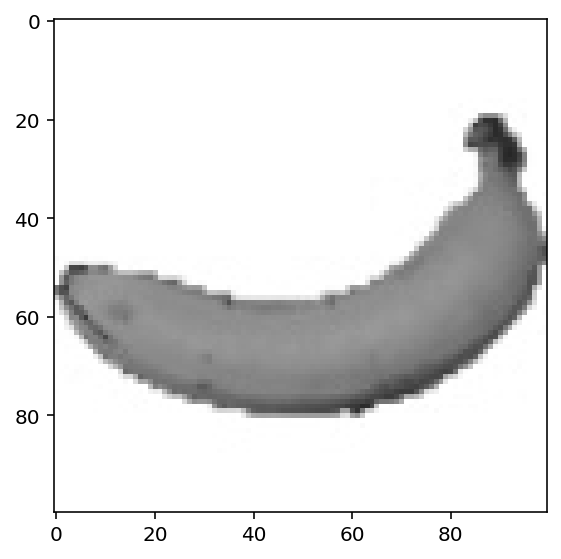

In [159]:
from skimage import io
import numpy as np
import matplotlib.pyplot as plt

# path to fruit360 dataset
path = '/home/gino/Desktop/fruits-360_dataset/'

def img_grayscale(image):
    return io.imread(image, as_gray=True)

banana_collection = io.ImageCollection(path + 'fruits-360/Training/Banana/*.jpg', load_func=img_grayscale)

io.imshow(banana_collection[180])
#print(banana_collection)

## Filtering

In [217]:
from skimage import filters

sample_banana = banana_collection[180]


### Gaussian filter

(100, 100)
float64


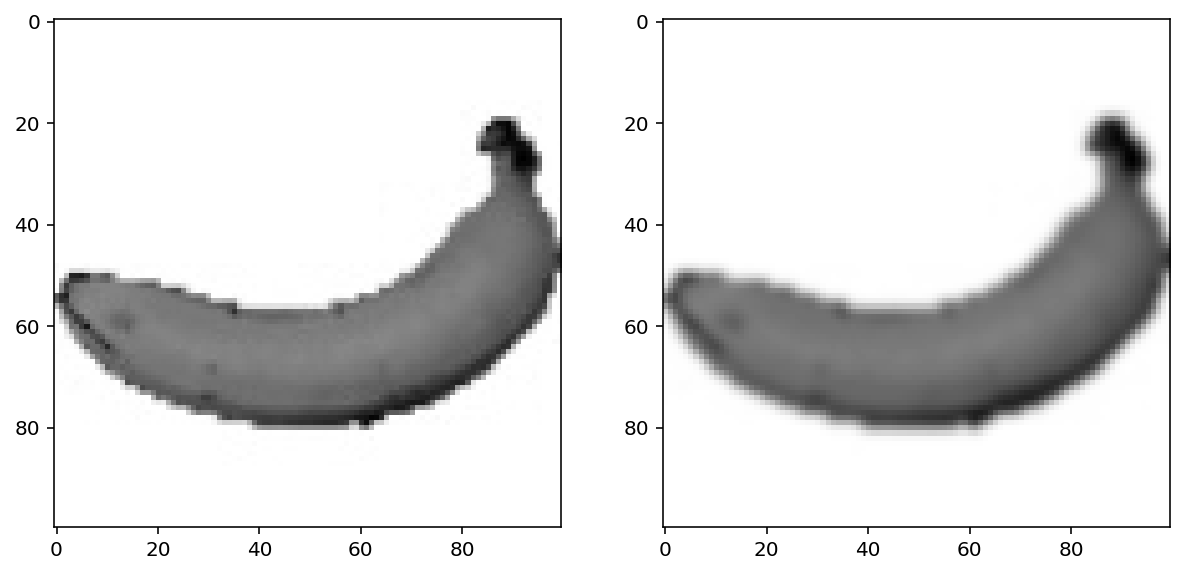

In [212]:

gauss_filtered = filters.gaussian(sample_banana, sigma=1)

print(gauss_filtered.shape)
print(sample_banana.dtype)

fig, ax = plt.subplots(1, 2)

ax[0].imshow(sample_banana, cmap='gray')
ax[1].imshow(gauss_filtered, cmap='gray')

fig.set_size_inches(10, 10)

### Edge detection: Sobel and Scharr filters

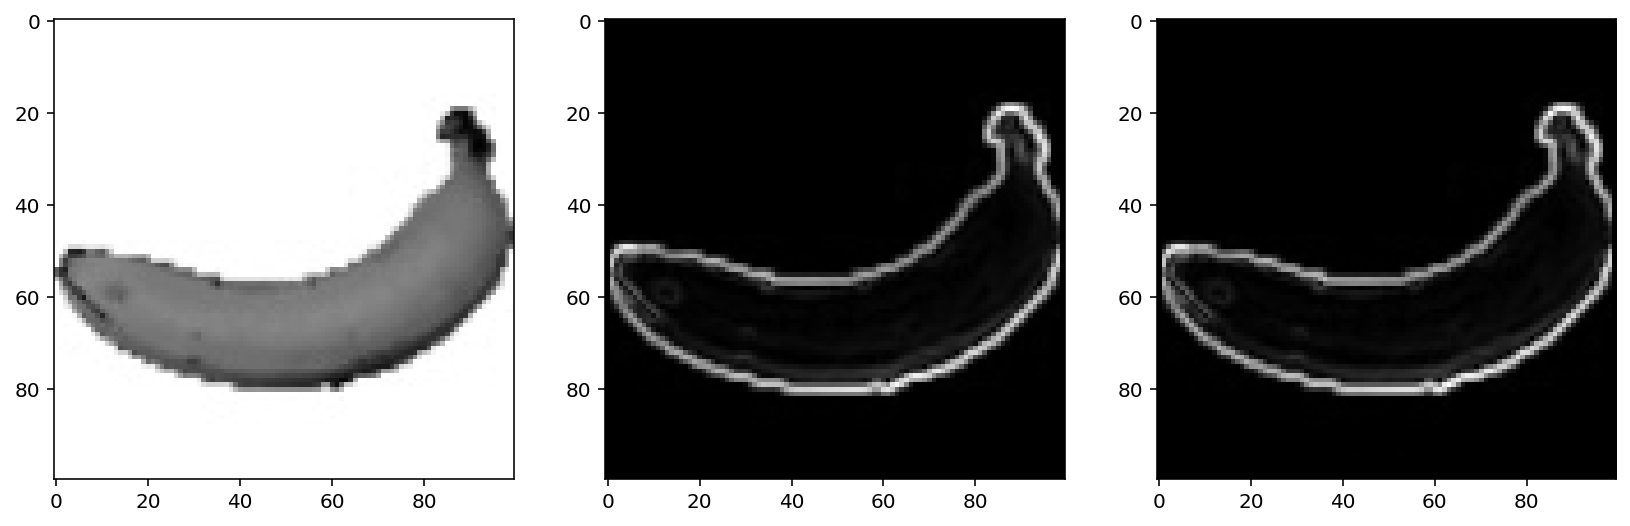

In [225]:
sobel_filtered = filters.sobel(sample_banana)

#plt.imshow(sample_banana, cmap='gray')

scharr_filtered = filters.scharr(sample_banana)

fig, ax = plt.subplots(1, 3)

ax[0].imshow(sample_banana, cmap='gray')
ax[1].imshow(sobel_filtered, cmap='gray')
ax[2].imshow(scharr_filtered, cmap='gray')

fig.set_size_inches(14, 14)

#plt.imshow(scharr_filtered - sobel_filtered, cmap='gray')

### Thresholding

Many techniques exist but given the quality of the dataset we will not require any fancy thresholding algorithms.

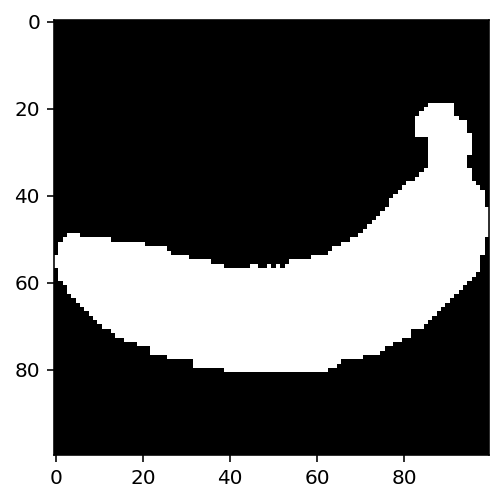

In [232]:
# Threshold value. Can be obtained algorithmically
threshold = 0.9

image = sample_banana > threshold

image = 1 - image

plt.imshow(image, cmap='gray')